# Tensorflow Implementation of VGG Face Detector

Objective: Convert the VGG face descriptor model http://www.robots.ox.ac.uk/~vgg/software/vgg_face/ to Tensorflow format.
<br>
Output: Final Tensorflow classifier model trained on the gender dataset

In [1]:
import scipy.io as sio
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, ZeroPadding2D, Convolution2D, MaxPooling2D, Dense, Dropout, Softmax, Flatten, Activation, BatchNormalization

Using TensorFlow backend.


## Read .mat file for Model Description

In [2]:
def load_mat():
    mat = sio.loadmat('data/vgg_face.mat', struct_as_record=False)
    return mat

mat = load_mat()
net = mat['net'][0][0]
mat_model = net.layers
mat_model_layers = mat_model[0]
num_mat_layers = mat_model_layers.shape[0]
for layer in mat_model_layers:
    print(layer[0][0].name)

['conv1_1']
['relu1_1']
['conv1_2']
['relu1_2']
['pool1']
['conv2_1']
['relu2_1']
['conv2_2']
['relu2_2']
['pool2']
['conv3_1']
['relu3_1']
['conv3_2']
['relu3_2']
['conv3_3']
['relu3_3']
['pool3']
['conv4_1']
['relu4_1']
['conv4_2']
['relu4_2']
['conv4_3']
['relu4_3']
['pool4']
['conv5_1']
['relu5_1']
['conv5_2']
['relu5_2']
['conv5_3']
['relu5_3']
['pool5']
['fc6']
['relu6']
['dropout6']
['fc7']
['relu7']
['dropout7']
['fc8']
['softmax']


## VGG Architecture Implementation
We can read the model described in the .mat file and build our tensorflow/keras model using clues. This way we can avoid reproducing it by hand. Additionally, this saves us the trouble of later applying the model weights from the .mat file to our tensorflow/keras model. The following implementation allows us to reproduce the VGG-Face model without having to create or train the model on our time. 

In [3]:
def vgg_tf():
    model = Sequential()

    for i in range(num_mat_layers):
        mat_model_layer = mat_model_layers[i][0][0].name[0]
        if mat_model_layer.find("conv") == 0 or mat_model_layer.find("fc") == 0:
            weights = mat_model_layers[i][0,0].weights
            weights_shape = weights[0][0].shape
            filter_x = weights_shape[0]; filter_y = weights_shape[1]
            number_of_filters = weights_shape[3]

            if mat_model_layer.find("conv") == 0:
                if i == 0:
                    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
                else:
                    model.add(ZeroPadding2D((1,1)))
            model.add(Convolution2D(number_of_filters, (filter_x, filter_y), name= mat_model_layer))

        else:
            if mat_model_layer.find("relu") == 0:
                model.add(Activation('relu', name=mat_model_layer))
            elif mat_model_layer.find("dropout") == 0:
                model.add(Dropout(0.5, name=mat_model_layer))
            elif mat_model_layer.find("pool") == 0:
                model.add(MaxPooling2D((2,2), strides=(2,2), name=mat_model_layer))
            elif mat_model_layer.find("softmax") == 0:
                model.add(Activation('softmax', name=mat_model_layer))

    return model

Save model to .h5 file for use later.

In [30]:
model_ = vgg_tf()
model_.save('data/vgg_face.h5')
# model = model_
model = Model(inputs=model_.layers[0].input,outputs=model_.layers[-2].output)

## Load Dataset

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import numpy as np
from tqdm import tqdm
import os

In [32]:
def pad(img):
    ht, wd, cc= img.shape
    ww = 224
    hh = 224
    color = (0,0,0)
    result = np.full((hh,ww,cc), color, dtype=np.uint8)
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2
    result[yy:yy+ht, xx:xx+wd] = img
    return result

def load_img_file(path, model):
    img = Image.open(path)
#     img = load_img(path)
    x = img_to_array(img) 
    x = pad(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = model(x)
    return x

def load_data(path, model):
    x = []
    y = []
    labels = {}
    folders = os.listdir(path)
    for i in tqdm(range(len(folders))):
        labels[i] = folders[i]
        label_path = path + '/' + folders[i]
        images = os.listdir(label_path)
        for image in images:
            img = load_img_file(label_path + '/' + image, model)
            x.append(np.squeeze(K.eval(img)).tolist())
            y.append(i)
    return np.array(x), np.array(y), labels

In [33]:
X_train = y_train = labels = None
try:
    X_train = np.load('data/combined/X_train.npy', allow_pickle=True)
    y_train = np.load('data/combined/y_train.npy', allow_pickle=True)
    labels = np.load('data/combined/labels.npy', allow_pickle=True)[()]
except:
    X_train, y_train, labels = load_data('data/combined/aligned', model)
    np.save('data/combined/X_train', X_train)
    np.save('data/combined/y_train', y_train)
    np.save('data/combined/labels', labels)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [05:59<00:00,  2.57s/it]


In [34]:
X_test = y_test = None
try:
    X_test = np.load('data/combined/X_test.npy', allow_pickle=True)
    y_test = np.load('data/combined/y_test.npy', allow_pickle=True)
    labels = np.load('data/combined/labels.npy', allow_pickle=True)[()]
except:
    X_test, y_test, labels = load_data('data/combined/valid', model)
    np.save('data/combined/X_test', X_test)
    np.save('data/combined/y_test', y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:45<00:00,  3.06it/s]


In [35]:
print(labels)

{0: '01_F', 1: '01_M', 2: '02_F', 3: '02_M', 4: '03_F', 5: '03_M', 6: '04_F', 7: '04_M', 8: '05_F', 9: '05_M', 10: '06_F', 11: '06_M', 12: '07_F', 13: '07_M', 14: '08_F', 15: '08_M', 16: '09_F', 17: '09_M', 18: '10_F', 19: '10_M', 20: '11_F', 21: '11_M', 22: '12_F', 23: '12_M', 24: '13_F', 25: '13_M', 26: '14_F', 27: '14_M', 28: '15_F', 29: '15_M', 30: '16_F', 31: '16_M', 32: '17_F', 33: '17_M', 34: '18_F', 35: '18_M', 36: '19_F', 37: '19_M', 38: '20_F', 39: '20_M', 40: '21_F', 41: '21_M', 42: '22_F', 43: '22_M', 44: '23_F', 45: '23_M', 46: '24_F', 47: '24_M', 48: '25_F', 49: '25_M', 50: '26_F', 51: '26_M', 52: '27_F', 53: '27_M', 54: '28_F', 55: '28_M', 56: '29_F', 57: '29_M', 58: '30_F', 59: '30_M', 60: '31_F', 61: '31_M', 62: '32_F', 63: '32_M', 64: '33_F', 65: '33_M', 66: '34_F', 67: '34_M', 68: '35_F', 69: '35_M', 70: '36_F', 71: '36_M', 72: '37_F', 73: '37_M', 74: '38_F', 75: '38_M', 76: '39_F', 77: '39_M', 78: '40_F', 79: '40_M', 80: '41_F', 81: '41_M', 82: '42_F', 83: '42_M', 8

## Construct Classifier 

In [43]:
def classier_model(input_dim, num_classes):
    classifier = Sequential()
    classifier.add(Dense(num_classes, input_dim=input_dim))
    classifier.add(Activation('softmax'))
    classifier.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='nadam', metrics=['accuracy'])
    return classifier

## Train Classifier

In [44]:
from matplotlib import pyplot as plt

def plotter(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Gender Classification

Train classifier for gender classification (of all ages together).

In [45]:
y_train_gender = np.copy(y_train)
y_test_gender = np.copy(y_test)
y_train_gender[y_train_gender % 2 == 0] = 0
y_train_gender[y_train_gender % 2 != 0] = 1
y_test_gender[y_test_gender % 2 == 0] = 0
y_test_gender[y_test_gender % 2 != 0] = 1

classifier = classier_model(2622, 2)
history = classifier.fit(X_train, y_train_gender, batch_size=16, epochs=100, validation_data=(X_test, y_test_gender))
classifier.save('data/gender_classifier.h5')

Epoch 1/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.6520 - accuracy: 0.6151 - val_loss: 0.6286 - val_accuracy: 0.6365
Epoch 2/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.6207 - accuracy: 0.6564 - val_loss: 0.6029 - val_accuracy: 0.6841
Epoch 3/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.6040 - accuracy: 0.6766 - val_loss: 0.5908 - val_accuracy: 0.6987
Epoch 4/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.5928 - accuracy: 0.6883 - val_loss: 0.5858 - val_accuracy: 0.7050
Epoch 5/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.5834 - accuracy: 0.6959 - val_loss: 0.5749 - val_accuracy: 0.7150
Epoch 6/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.5761 - accuracy: 0.7037 - val_loss: 0.5796 - val_accuracy: 0.7101
Epoch 7/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.5698 - accuracy: 0.7084 - val_loss: 0.5743 - val_ac

1840/1840 [==============================] - 3s 1ms/step - loss: 0.4931 - accuracy: 0.7617 - val_loss: 0.5104 - val_accuracy: 0.7449
Epoch 58/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.4917 - accuracy: 0.7634 - val_loss: 0.5033 - val_accuracy: 0.7634
Epoch 59/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.4919 - accuracy: 0.7652 - val_loss: 0.4995 - val_accuracy: 0.7664
Epoch 60/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.4920 - accuracy: 0.7622 - val_loss: 0.4997 - val_accuracy: 0.7626
Epoch 61/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.4914 - accuracy: 0.7649 - val_loss: 0.5068 - val_accuracy: 0.7503
Epoch 62/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.4910 - accuracy: 0.7645 - val_loss: 0.5059 - val_accuracy: 0.7609
Epoch 63/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.4904 - accuracy: 0.7649 - val_loss: 0.4983 - val_accuracy

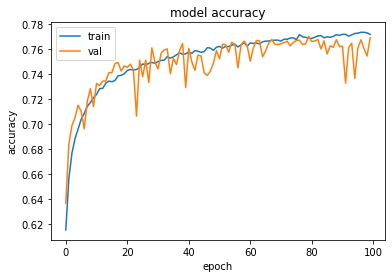

In [46]:
plotter(history)

### Age Group Classification
Train classifier to recognize the different age groups (not taking into account gender).

In [42]:
def labels(y):
    t = 0
    for i in range(0, 140, 2):
        y[ y == i ] = t
        y[ y == i+1 ] = t
        t += 1
    return y

y_train_age = labels(np.copy(y_train))
y_test_age = labels(np.copy(y_test))
print(y_train_age)

classifier = classier_model(2622, 70)
history = classifier.fit(X_train, y_train_age, batch_size=16, epochs=100, validation_data=(X_test, y_test_age))
classifier.save('data/age_classifier.h5')

[ 0  0  0 ... 69 69 69]
Epoch 1/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.2780 - accuracy: 0.0179 - val_loss: 4.2543 - val_accuracy: 0.0255
Epoch 2/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.2299 - accuracy: 0.0243 - val_loss: 4.2395 - val_accuracy: 0.0280
Epoch 3/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.2048 - accuracy: 0.0267 - val_loss: 4.1993 - val_accuracy: 0.0277
Epoch 4/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.1837 - accuracy: 0.0318 - val_loss: 4.2040 - val_accuracy: 0.0304
Epoch 5/100
1840/1840 [==============================] - 3s 2ms/step - loss: 4.1655 - accuracy: 0.0318 - val_loss: 4.1894 - val_accuracy: 0.0253
Epoch 6/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.1495 - accuracy: 0.0357 - val_loss: 4.1843 - val_accuracy: 0.0326
Epoch 7/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.1343 - accuracy: 0.0354 - v

1840/1840 [==============================] - 3s 1ms/step - loss: 3.7694 - accuracy: 0.0923 - val_loss: 4.0269 - val_accuracy: 0.0516
Epoch 58/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7657 - accuracy: 0.0971 - val_loss: 4.0388 - val_accuracy: 0.0454
Epoch 59/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7590 - accuracy: 0.0973 - val_loss: 4.0404 - val_accuracy: 0.0467
Epoch 60/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7536 - accuracy: 0.0984 - val_loss: 4.0382 - val_accuracy: 0.0448
Epoch 61/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7510 - accuracy: 0.0976 - val_loss: 4.0208 - val_accuracy: 0.0454
Epoch 62/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7456 - accuracy: 0.1015 - val_loss: 4.0495 - val_accuracy: 0.0454
Epoch 63/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7432 - accuracy: 0.1007 - val_loss: 4.0432 - val_accuracy

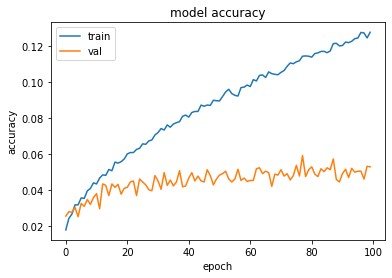

In [43]:
plotter(history)

### Classifier on the overall dataset

Train classifier on all the classes.

Epoch 1/100
920/920 [==============================] - 1s 2ms/step - loss: 4.9387 - accuracy: 0.0110 - val_loss: 4.8987 - val_accuracy: 0.0185
Epoch 2/100
920/920 [==============================] - 1s 2ms/step - loss: 4.8774 - accuracy: 0.0156 - val_loss: 4.8919 - val_accuracy: 0.0141
Epoch 3/100
920/920 [==============================] - 1s 2ms/step - loss: 4.8427 - accuracy: 0.0176 - val_loss: 4.8573 - val_accuracy: 0.0190
Epoch 4/100
920/920 [==============================] - 1s 2ms/step - loss: 4.8134 - accuracy: 0.0208 - val_loss: 4.8509 - val_accuracy: 0.0155
Epoch 5/100
920/920 [==============================] - 1s 2ms/step - loss: 4.7878 - accuracy: 0.0226 - val_loss: 4.8253 - val_accuracy: 0.0201
Epoch 6/100
920/920 [==============================] - 1s 2ms/step - loss: 4.7676 - accuracy: 0.0242 - val_loss: 4.8228 - val_accuracy: 0.0225
Epoch 7/100
920/920 [==============================] - 1s 2ms/step - loss: 4.7462 - accuracy: 0.0279 - val_loss: 4.8058 - val_accuracy: 0.0166

Epoch 58/100
920/920 [==============================] - 1s 2ms/step - loss: 4.2357 - accuracy: 0.0939 - val_loss: 4.6546 - val_accuracy: 0.0350
Epoch 59/100
920/920 [==============================] - 1s 2ms/step - loss: 4.2300 - accuracy: 0.0972 - val_loss: 4.6437 - val_accuracy: 0.0369
Epoch 60/100
920/920 [==============================] - 1s 2ms/step - loss: 4.2240 - accuracy: 0.0959 - val_loss: 4.6649 - val_accuracy: 0.0353
Epoch 61/100
920/920 [==============================] - 1s 2ms/step - loss: 4.2153 - accuracy: 0.0959 - val_loss: 4.6616 - val_accuracy: 0.0356
Epoch 62/100
920/920 [==============================] - 1s 2ms/step - loss: 4.2102 - accuracy: 0.0996 - val_loss: 4.6435 - val_accuracy: 0.0364
Epoch 63/100
920/920 [==============================] - 1s 2ms/step - loss: 4.2035 - accuracy: 0.0998 - val_loss: 4.6568 - val_accuracy: 0.0405
Epoch 64/100
920/920 [==============================] - 1s 2ms/step - loss: 4.1988 - accuracy: 0.1024 - val_loss: 4.6422 - val_accuracy:

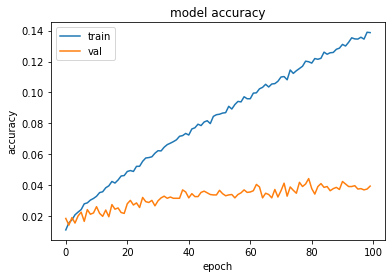

In [47]:
classifier = classier_model(2622, 140)
history = classifier.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))
classifier.save('data/overall.h5')
plotter(history)

## Results

From the expirements we were able to achieve a 80% accuracy detecting gender from images. The same cannot be said for detecting age, which is much hard just given the face and so many adjacent age groups. Overall, trying to recognize 140 different classes that share a lot of similarities is very difficult and delivers poor results. 

We conclude that VGG-face model along with a classifier can effectively be used to identify gender with 80% confidence.